# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential   
from keras.layers import LSTM            
from keras.layers import Dense           
from keras.layers import Dropout   
from keras.callbacks import EarlyStopping

# Load Dataset

In [36]:
dataset = pd.read_csv("TSLA.csv")
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


# Split Dataset into Train and Test set

In [37]:
split_row = len(dataset)- int(0.2 * len(dataset))
train_data = dataset.iloc[:split_row]
test_data = dataset.iloc[split_row:]

## Selecting only Open,Close,High,Low values from Dataset

In [38]:
traincol = train_data.iloc[:, 1:5].values
testcol = test_data.iloc[:, 1:5].values
print("SHAPE OF TRAIN DATA :",traincol.shape)
print("SHAPE OF TEST DATA :",testcol.shape)

SHAPE OF TRAIN DATA : (1933, 4)
SHAPE OF TEST DATA : (483, 4)


# Visualise Close value of Dataset

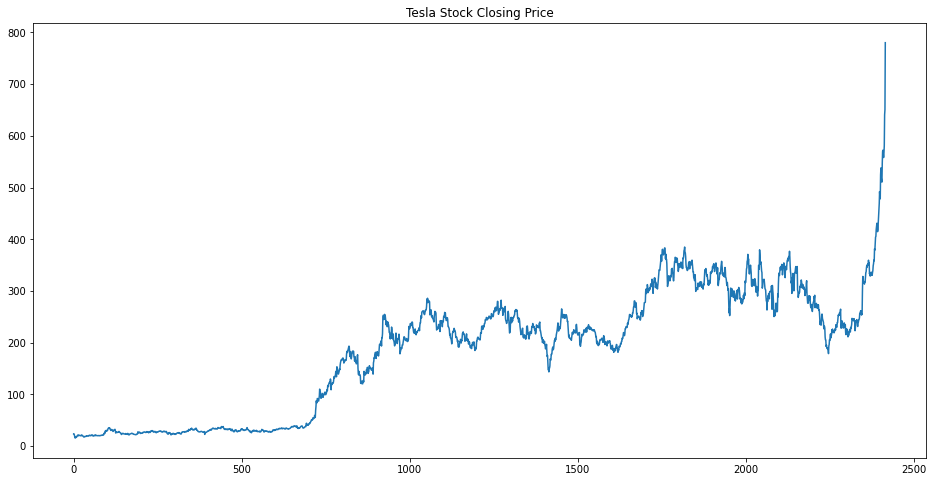

In [39]:
plt.figure(figsize=(16,8))
plt.plot(dataset["Close"])
plt.title("Tesla Stock Closing Price")
plt.show()


## Reshape and Scale the Data

In [40]:
train_shaped = np.reshape(traincol, (-1,1))
test_shaped = np.reshape(testcol, (-1,1))
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_shaped)
print("Shape of Scaled_train",scaled_train.shape)

Shape of Scaled_train (7732, 1)


# Creating data with Timesteps

In [41]:
def timesteps(scaled_train):
    X_train = []
    y_train = []
    time_steps = 60
    for i in range(time_steps, len(scaled_train)):
        X_train.append(scaled_train[i-time_steps:i,0])
        y_train.append(scaled_train[i,0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = np.reshape(y_train, (-1,1))
    return X_train,y_train

X_train,y_train = timesteps(scaled_train) 
print("Size of X_train",X_train.shape)
print("Size of y_train",y_train.shape)  

Size of X_train (7672, 60, 1)
Size of y_train (7672, 1)


# Build LSTM Model

In [32]:
regressor=Sequential()
"""return_sequences=True ; to return  the full sequence output
   input_shape: is the shape of training set
   units :is the dimension of cell in LSTM"""
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (60,1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))
          
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
          
regressor.add(Dense(units=1))
          
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

# Compile the model and fit the model

In [33]:
callback = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
regressor.compile(optimizer="adam",loss="mean_squared_error")
model=regressor.fit(X_train,y_train,epochs=50,batch_size=32,validation_split=0.1,verbose=1, callbacks=[callback])

Epoch 1/50
216/216 [==============================] - 22s 76ms/step - loss: 0.0189 - val_loss: 0.0012
Epoch 2/50
216/216 [==============================] - 16s 72ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 3/50
216/216 [==============================] - 15s 70ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 4/50
216/216 [==============================] - 14s 67ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 5/50
216/216 [==============================] - 15s 70ms/step - loss: 0.0012 - val_loss: 8.7958e-04
Epoch 6/50
216/216 [==============================] - 16s 73ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 7/50
216/216 [==============================] - 16s 72ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 8/50
216/216 [==============================] - 17s 77ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 9/50
216/216 [==============================] - 15s 70ms/step - loss: 9.8300e-04 - val_loss: 6.6673e-04
Epoch 10/50
216/216 [==============================] - 15s 70ms/step -

## Visualising Training and Validation Loss

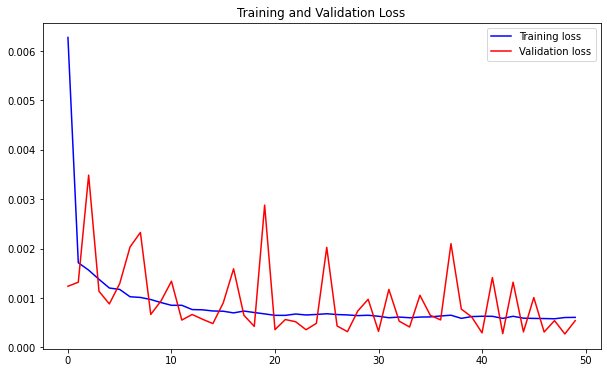

In [34]:
loss = model.history['loss']
val_loss = model.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Testing the Model

### Merge train and test data on axis=0
### we need the 60 days’ price before the 1st date in the test dataset

In [42]:
dataset.drop(['Date', 'Adj Close','Volume'], axis = 1,inplace=True)
model_input = dataset[len(dataset) - len(test_data) - 60:].values
print("SHAPE OF MODELINPUT",model_input.shape)
print("model_input :",model_input)

SHAPE OF MODELINPUT (543, 4)
model_input : [[302.       308.       301.       303.700012]
 [300.100006 313.390015 300.       313.26001 ]
 [312.       318.630005 311.049988 311.23999 ]
 ...
 [632.419983 650.880005 618.       640.809998]
 [640.       653.       632.52002  650.570007]
 [673.690002 786.140015 673.52002  780.      ]]


## Reshape and Scale the Training Data

In [43]:
model_input_reshaped = np.reshape(model_input, (-1,1))
model_input_reshaped=scaler.fit_transform(model_input_reshaped)
model_input_reshaped.shape

(2172, 1)

# Creating data with Timesteps

In [44]:

time_steps= 60
X_test = []
y_test = []
for i in range (60, len(model_input_reshaped)):
    X_test.append(model_input_reshaped[i-time_steps:i,0]) 
    y_test.append(model_input_reshaped[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test) 
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, (-1,1))
print("shape of X_test ",X_test.shape)
print("shape of y_test ",y_test.shape)

shape of X_test  (2112, 60, 1)
shape of y_test  (2112, 1)


## Predicting Stock Price using Test  Data

In [45]:
y_pred = regressor.predict(X_test) 
y_pred = scaler.inverse_transform(y_pred)
#Rescale the predicted data
y_test = scaler.inverse_transform(y_test)
y_test.shape

(2112, 1)

In [46]:
print("prediction",y_pred)
print("actual",y_test)

prediction [[318.62726]
 [316.94232]
 [315.7712 ]
 ...
 [648.40405]
 [707.69055]
 [738.2587 ]]
actual [[316.      ]
 [317.679993]
 [310.75    ]
 ...
 [786.140015]
 [673.52002 ]
 [780.      ]]


# Visualise Actual vs Predicted Stock Price

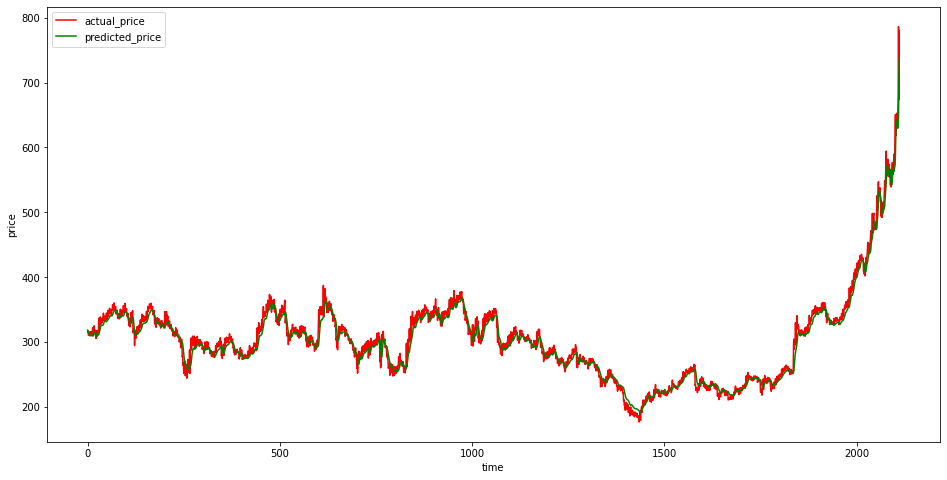

In [47]:
plt.figure(figsize=(16,8))
plt.plot(y_test,color="red",label="actual_price")
plt.plot(y_pred,color=("green"),label="predicted_price")
plt.xlabel("time")
plt.ylabel("price")
plt.legend()
plt.show()